# とりあえずデータを観察する

In [45]:
import collections
import pathlib

# データ処理周り
import numpy as np
import pandas as pd
from IPython.core.display import display

# 可視化ライブラリ
import matplotlib.pyplot as plt
from matplotlib import cm # colormap
import seaborn as sns
%matplotlib inline

# pandasのwarningが邪魔なので
import warnings
warnings.filterwarnings('ignore')

# options
# pd.set_option('display.max_columns', 50)
plt.style.use('ggplot')

In [46]:
data_path = pathlib.Path("../data")

## ファイル読み込み

train.csvは、184,903,891行(8GB)あるのでそのまま読み込みは厳しい。  
100,000行サンプリングされたデータと、testデータを読み込んでデータの概要を確認

In [47]:
train = pd.read_csv(data_path / "train_sample.csv", parse_dates=['click_time'])
train.shape

(100000, 8)

In [48]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


- ip: ip address of click.
- app: app id for marketing.
- device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
- os: os version id of user mobile phone
- channel: channel id of mobile ad publisher
- click_time: timestamp of click (UTC)


*train only*
- attributed_time: appをダウンロードした場合はその時間が入っている
- is_attributed: the target that is to be predicted, indicating the app was downloaded

In [49]:
test = pd.read_csv(data_path / "test.csv", parse_dates=['click_time'])
test.shape

(18790469, 7)

In [50]:
test.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


In [51]:
submission = pd.read_csv(data_path / 'sample_submission.csv')[:100]
submission.shape

(100, 2)

In [52]:
submission.head()

,click_id,is_attributed
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


## ip, app, device, os, channnel, click_timeの分布を基礎集計

### ip

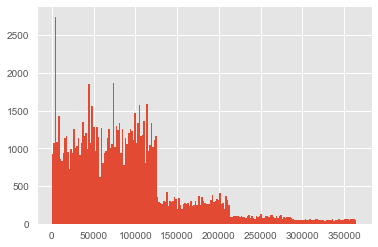

In [53]:
train.ip.hist(bins=200)

### app

In [55]:
apps = train.groupby('app').ip.count()
apps.shape

(161,)

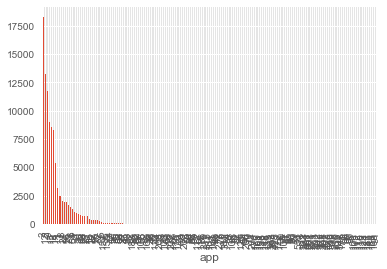

In [56]:
apps.sort_values(ascending=False).plot.bar()

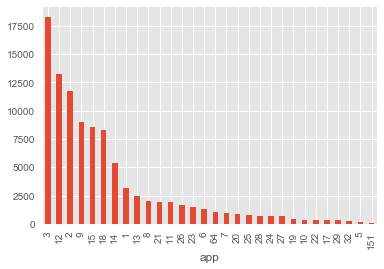

In [57]:
apps.sort_values(ascending=False)[:30].plot.bar()

- appはサンプルだと161種類
- データ数がそこそこあるのは30種類くらい

### channel

In [58]:
channels = train.groupby('channel').ip.count()
channels.shape

(161,)

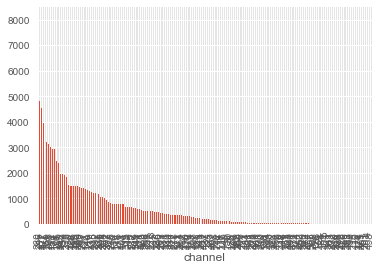

In [60]:
channels.sort_values(ascending=False).plot.bar()

### device

In [61]:
devices = train.groupby('device').ip.count()
devices.shape

(100,)

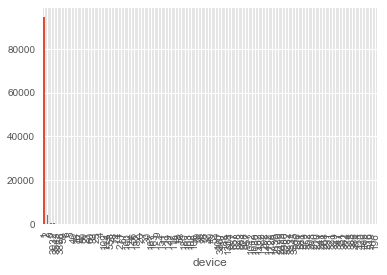

In [64]:
devices.sort_values(ascending=False).plot.bar()

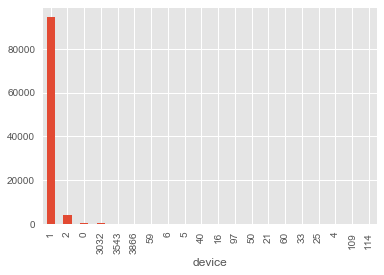

In [65]:
devices.sort_values(ascending=False)[:20].plot.bar()

- 多いのはトップ6種類くらい
- 0,1,2,3032, 3543, 3866

なんか飛んでるから４桁の方は不正なやつなんじゃないだろか(ただの予想)


### OS

In [66]:
oss = train.groupby('os').ip.count()
oss.shape

(130,)

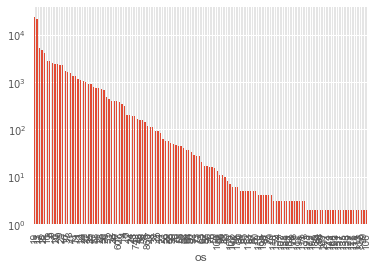

In [67]:
oss.sort_values(ascending=False).plot.bar(log=True)

これはそこそこばらついてそう。。。

### click_time

In [68]:
date = pd.to_datetime(train.click_time).dt.date
date.head()

0    2017-11-07
1    2017-11-07
2    2017-11-07
3    2017-11-07
4    2017-11-09
Name: click_time, dtype: object

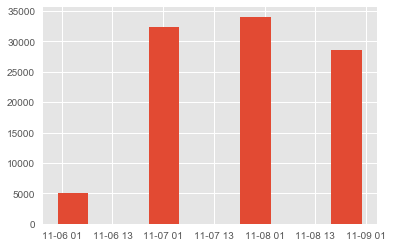

In [69]:
date.hist()

In [70]:
hour = pd.to_datetime(train.click_time).dt.hour
hour.head()

0     9
1    13
2    18
3     4
4     9
Name: click_time, dtype: int64

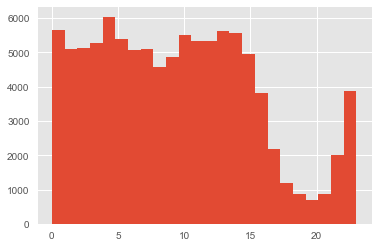

In [71]:
hour.hist(bins=24)

24~15時のアクセスが多い

## trainとtestの関係

IPが含まれている率

In [72]:
train.ip.isin(test.ip).mean()

0.79922

train 10000件で80%ちかく含まれているということはだいたいのuserがカバーできてる？
全体で見たほうが良さそう

### 全データのIPとtestIP

In [73]:
train_all = pd.read_csv(data_path / 'train.csv',  usecols=['ip'])

In [74]:
train_all_ip = train_all.ip.unique()

In [75]:
test.ip.isin(train_all_ip).mean()

0.9187299156822536

testデータのipのうち91%はtrainデータにも存在する

## コンバージョン(DL)と各指標の関係

### データ加工

In [76]:
train.loc[:, "DL"] = (~train.attributed_time.isnull()).astype(int)
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,DL
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0,0


In [77]:
train.loc[:, "hour"] = pd.to_datetime(train.click_time).dt.hour
train.loc[:, "date"] = pd.to_datetime(train.click_time).dt.date
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,DL,hour,date
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0,0,9,2017-11-07
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0,0,13,2017-11-07
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0,0,18,2017-11-07
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0,0,4,2017-11-07
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0,0,9,2017-11-09


In [84]:
## ip, os, device, appごとのクリックまでの間隔
train.sort_values(by='click_time', inplace=True)

In [123]:
train['next_click'] =np.abs(train.groupby(['ip', 'os', 'device', 'app']).click_time.diff(-1).dt.total_seconds())
train['prev_click'] = np.abs(train.groupby(['ip', 'os', 'device', 'app']).click_time.diff(1).dt.total_seconds())

In [124]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,DL,hour,date,prev_click,next_click
54955,48646,12,1,19,178,2017-11-06 16:00:00,NaN,0,0,16,2017-11-06,NaN,NaN
28314,93836,12,1,30,328,2017-11-06 16:00:09,NaN,0,0,16,2017-11-06,NaN,NaN
31830,5314,8,1,13,145,2017-11-06 16:00:09,NaN,0,0,16,2017-11-06,NaN,75608.0
99357,73954,23,1,19,153,2017-11-06 16:00:11,NaN,0,0,16,2017-11-06,NaN,NaN
83228,91574,3,1,17,135,2017-11-06 16:00:11,NaN,0,0,16,2017-11-06,NaN,NaN


In [133]:
i = 0
for t, df in train.groupby(['ip', 'os', 'device', 'app']):
    if df.shape[0] > 2:
        i += 1
        if i > 10:
            break
        display(df)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,DL,hour,date,prev_click,next_click
70953,2805,3,1,19,280,2017-11-09 06:41:56,NaN,0,0,6,2017-11-09,NaN,24837.0
79743,2805,3,1,19,417,2017-11-09 13:35:53,NaN,0,0,13,2017-11-09,24837.0,822.0
45931,2805,3,1,19,115,2017-11-09 13:49:35,NaN,0,0,13,2017-11-09,822.0,1927.0
82879,2805,3,1,19,137,2017-11-09 14:21:42,NaN,0,0,14,2017-11-09,1927.0,NaN


,ip,app,device,os,channel,click_time,attributed_time,is_attributed,DL,hour,date,prev_click,next_click
71053,2810,3,1,13,280,2017-11-07 11:48:10,NaN,0,0,11,2017-11-07,NaN,45340.0
70129,2810,3,1,13,115,2017-11-08 00:23:50,NaN,0,0,0,2017-11-08,45340.0,102458.0
60516,2810,3,1,13,173,2017-11-09 04:51:28,NaN,0,0,4,2017-11-09,102458.0,NaN


,ip,app,device,os,channel,click_time,attributed_time,is_attributed,DL,hour,date,prev_click,next_click
55997,3279,3,1,19,115,2017-11-08 07:36:20,NaN,0,0,7,2017-11-08,NaN,13383.0
48475,3279,3,1,19,280,2017-11-08 11:19:23,NaN,0,0,11,2017-11-08,13383.0,55338.0
79489,3279,3,1,19,409,2017-11-09 02:41:41,NaN,0,0,2,2017-11-09,55338.0,NaN


,ip,app,device,os,channel,click_time,attributed_time,is_attributed,DL,hour,date,prev_click,next_click
92807,3994,3,1,19,135,2017-11-07 11:30:32,NaN,0,0,11,2017-11-07,NaN,1575.0
5291,3994,3,1,19,489,2017-11-07 11:56:47,NaN,0,0,11,2017-11-07,1575.0,54051.0
83926,3994,3,1,19,280,2017-11-08 02:57:38,NaN,0,0,2,2017-11-08,54051.0,NaN


,ip,app,device,os,channel,click_time,attributed_time,is_attributed,DL,hour,date,prev_click,next_click
13285,3994,18,1,19,30,2017-11-08 02:32:29,NaN,0,0,2,2017-11-08,NaN,64499.0
71013,3994,18,1,19,107,2017-11-08 20:27:28,NaN,0,0,20,2017-11-08,64499.0,65405.0
27160,3994,18,1,19,134,2017-11-09 14:37:33,NaN,0,0,14,2017-11-09,65405.0,NaN


,ip,app,device,os,channel,click_time,attributed_time,is_attributed,DL,hour,date,prev_click,next_click
88227,4019,3,1,13,424,2017-11-07 04:56:47,NaN,0,0,4,2017-11-07,NaN,129793.0
98387,4019,3,1,13,452,2017-11-08 17:00:00,NaN,0,0,17,2017-11-08,129793.0,13463.0
16103,4019,3,1,13,211,2017-11-08 20:44:23,NaN,0,0,20,2017-11-08,13463.0,NaN


,ip,app,device,os,channel,click_time,attributed_time,is_attributed,DL,hour,date,prev_click,next_click
43419,4019,9,1,13,258,2017-11-07 06:51:24,NaN,0,0,6,2017-11-07,NaN,161131.0
93370,4019,9,1,13,107,2017-11-09 03:36:55,NaN,0,0,3,2017-11-09,161131.0,462.0
49327,4019,9,1,13,215,2017-11-09 03:44:37,NaN,0,0,3,2017-11-09,462.0,NaN


,ip,app,device,os,channel,click_time,attributed_time,is_attributed,DL,hour,date,prev_click,next_click
13693,4052,12,1,13,140,2017-11-06 21:37:24,NaN,0,0,21,2017-11-06,NaN,17325.0
24801,4052,12,1,13,328,2017-11-07 02:26:09,NaN,0,0,2,2017-11-07,17325.0,210466.0
58608,4052,12,1,13,140,2017-11-09 12:53:55,NaN,0,0,12,2017-11-09,210466.0,3746.0
83682,4052,12,1,13,340,2017-11-09 13:56:21,NaN,0,0,13,2017-11-09,3746.0,NaN


,ip,app,device,os,channel,click_time,attributed_time,is_attributed,DL,hour,date,prev_click,next_click
65082,4052,3,1,19,211,2017-11-08 04:33:09,NaN,0,0,4,2017-11-08,NaN,13418.0
40439,4052,3,1,19,424,2017-11-08 08:16:47,NaN,0,0,8,2017-11-08,13418.0,10905.0
2645,4052,3,1,19,424,2017-11-08 11:18:32,NaN,0,0,11,2017-11-08,10905.0,NaN


,ip,app,device,os,channel,click_time,attributed_time,is_attributed,DL,hour,date,prev_click,next_click
89559,4052,12,1,19,145,2017-11-07 11:20:01,NaN,0,0,11,2017-11-07,NaN,92790.0
28364,4052,12,1,19,178,2017-11-08 13:06:31,NaN,0,0,13,2017-11-08,92790.0,23157.0
41777,4052,12,1,19,265,2017-11-08 19:32:28,NaN,0,0,19,2017-11-08,23157.0,NaN


## 人ごとにrandom forest

In [ ]:
g = train.groupby(['ip', 'os', 'device']).

In [ ]:
users = g[['DLsum', 'cnt']]
users.head()

### 人ごとのクリックカウント

In [ ]:
from sklearn.cluster import KMeans
k = 4

In [ ]:
sorted_cnt = users.sort_values(by='cnt').reset_index()
cluster = KMeans(n_clusters=k).fit(sorted_cnt[['cnt']])

In [ ]:
sorted_cnt.loc[:, 'cluster'] = cluster.labels_

In [ ]:
colors = cm.Accent.colors
for i in range(k):
    plt.plot(sorted_cnt[sorted_cnt.cluster == i]['cnt'], c=colors[i], linewidth=2)

In [ ]:
sorted_cnt.loc[:, 'rate'] = sorted_cnt['DLsum']/sorted_cnt['cnt']
df = sorted_cnt[sorted_cnt.cluster == 0]
df.head()

In [ ]:
sorted_cnt.groupby('cluster').agg({'rate': ['mean', 'count'], 'cnt': ['mean','sum']})

In [ ]:
sorted_cnt.rate.mean()

## ユーザごと・アプリごと

そろそろカーネルみよ・・・。

In [ ]:
g = train.groupby(['ip', 'os', 'device', 'app']).agg({'DL': 'sum', 'channel': 'count'}).reset_index()
g = g.rename(columns={'DL': 'DLsum', 'channel': 'cnt'})
g.head()

## 時系列diff

In [39]:
df = pd.DataFrame({
    'ip': [1,1,2,2,1],
    'time': ['2017-01-01 0:00', '2017-01-01 1:00', '2017-01-01 0:00', '2017-01-01 5:00', '2017-01-01 3:00'] ,
}).astype({'ip': 'uint32'})
df.time = pd.to_datetime(df.time)

In [40]:
df.groupby('ip').time - df.groupby('ip').time

TypeError: unsupported operand type(s) for -: 'SeriesGroupBy' and 'SeriesGroupBy'

In [117]:
df.groupby('ip').time.diff().dt.total_seconds()

0        NaN
1     3600.0
2        NaN
3    18000.0
4     7200.0
Name: time, dtype: float64